### <font style="color:blue">Project 2: Kaggle Competition - Classification</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Data Loader</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Configuration</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Evaluation Metric</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Train and Validation</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Model</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>Utils</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>Experiment</h3></td><td><h3>5</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>TensorBoard Dev Scalars Log Link</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>9</h3></td> <td><h3>Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>


## <font style="color:green">1. Data Loader [10 Points]</font>

In this section, you have to write a class or methods, which will be used to get training and validation data loader.

You need to write a custom dataset class to load data.

**Note; There is   no separate validation data. , You will thus have to create your own validation set, by dividing the train data into train and validation data. Usually, we do 80:20 ratio for train and validation, respectively.**


For example:

```python
class KenyanFood13Dataset(Dataset):
    """
    
    """
    
    def __init__(self, *args):
    ....
    ...
    
    def __getitem__(self, idx):
    ...
    ...
    

```


```python
def get_data(args1, *args):
    ....
    ....
    return train_loader, test_loader
```

In [7]:
pip install livelossplot

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [8]:
import random
import torch
from torch import nn
import torchmetrics
from torchsummary import summary
from PIL import Image, ImageOps
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image
from torchvision import transforms, models
import  torch.nn.functional as F

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time

import os
import itertools
from dataclasses import dataclass
import pandas as pd
import numpy as np

from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
from datetime import datetime 
from livelossplot import PlotLosses
from torch.utils.tensorboard import SummaryWriter
from livelossplot.outputs import MatplotlibPlot, ExtremaPrinter

In [9]:
def set_seed(seed=42):
    random.seed(seed)                # Python
    np.random.seed(seed)             # NumPy
    torch.manual_seed(seed)          # PyTorch CPU
    torch.cuda.manual_seed(seed)     # PyTorch GPU
    torch.cuda.manual_seed_all(seed) # multi-GPU
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_ref = np.random.randint(100)
set_seed(39) # 38 56
seed_ref
#pip freeze > requirements.txt


9

In [10]:
root_path = "/kaggle/input/opencv-pytorch-project-2-classification-round-3"
test_path = os.path.join(root_path, 'test.csv')
train_path = os.path.join(root_path, 'train.csv')
submission_path = os.path.join(root_path, 'sample_submission.csv')
image_path = os.path.join(root_path, 'images/images')

In [11]:
df_train = pd.read_csv(train_path)
df_train['id'] = df_train['id'].astype(str)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6536 entries, 0 to 6535
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6536 non-null   object
 1   class   6536 non-null   object
dtypes: object(2)
memory usage: 102.2+ KB


Nombre de class: 13


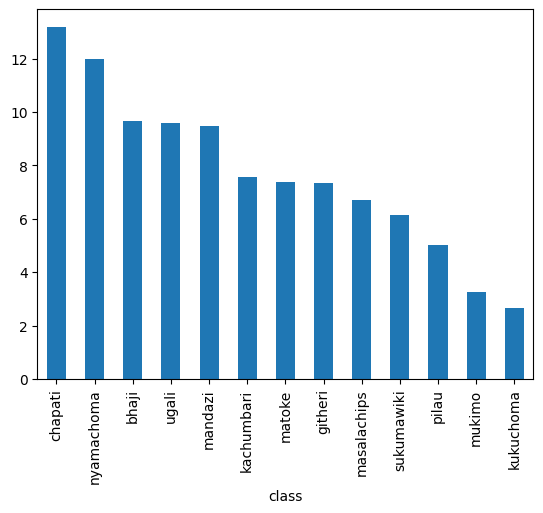

In [12]:
class_label = sorted(df_train['class'].unique())
print(f'Nombre de class: {len(class_label)}')
(df_train['class'].value_counts(normalize=True) * 100).plot.bar()
plt.show()

In [13]:
train_dict = {}
for idx, label in zip(df_train['id'], df_train['class']):
    if not label in train_dict:
        train_dict[label] = [idx + 'jpg']
    else:
       train_dict[label].append(idx + 'jpg') 

In [14]:
class KenyanFood13Dataset(Dataset):
    def __init__(self, df, size, img_path, train=True, transform=None):
        self.train = train
        self.size = size
        self.df = df

        # Handle image paths
        self.df['id'] = self.df['id'].astype(str)
        self.imgs = [os.path.join(img_path, f"{id_img}.jpg") for id_img in self.df['id'].values]

        # Handle labels (only for train/val)
        if self.train:
            self.labels = sorted(self.df['class'].unique())
            self.num_classes = len(self.labels)
            self.label_level = {label: i for i, label in enumerate(self.labels)}
            self.label_ordinal = torch.tensor([self.label_level[label] for label in self.df['class']], dtype=torch.long)

            # Class weights
            class_counts = np.bincount(self.label_ordinal.numpy())
            total_samples = len(self.label_ordinal)
            class_weights = np.array([total_samples / c for c in class_counts], dtype=np.float32)
            self.class_weights = torch.tensor(class_weights, dtype=torch.float)

        # Transformation
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor()
            ])
        else:
            self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(self.imgs[idx]).convert("RGB")
        img = self.transform(img)
        if self.train:
            label = self.label_ordinal[idx]
            return img, label
        else:
            return img

    def __len__(self):
        return len(self.imgs)


torch.Size([299, 299, 3]) bhaji


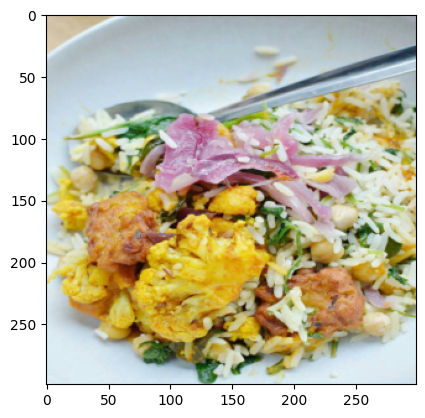

In [15]:
train_dataset = KenyanFood13Dataset(df = df_train, size = (299, 299), img_path = image_path,  train = True)
rd_idx = np.random.randint(100)
img = train_dataset[rd_idx][0]
label = train_dataset[rd_idx][1]
img = img.permute(1,2,0)
plt.imshow(img)
print(img.shape, train_dataset.labels[label])

In [16]:
def get_mean_std(df_train, size, img_path, batch_size = 128, num_workers = 4):
    
    train_dataset = KenyanFood13Dataset(df = df_train, size = size, img_path = image_path,  train = True)
    loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
    mean = 0.
    std = 0.
    total = 0

    for imgs, _ in loader:
        batch_samples = imgs.size(0)
        imgs = imgs.view(batch_samples, imgs.size(1), -1)  # [batch, C, pixels]
        mean += imgs.mean(2).sum(0)
        std += imgs.std(2).sum(0)
        total += batch_samples

    mean /= total
    std /= total

    return mean, std

In [17]:
#mean, std = get_mean_std(train_path, (299, 299), image_path)

In [19]:
def get_data(train_path, test_path, size, img_path, data_aug = True, batch_size = 64, num_workers = 4):

    mean_data = [0.5673, 0.4664, 0.3659]
    std_data = [0.2475, 0.2552, 0.2591]
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    # Train dataset
    val_transform = transforms.Compose([
        transforms.Resize(260),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
    
    if data_aug:
        train_transform = transforms.Compose([
            # Geometric
            transforms.Resize(300),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.90, 1.1)),
            transforms.CenterCrop(size),
            
            # Lighting
            transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.03),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.08),
            # Occlusion and normalisation
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
            transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.2, 1.8), value='random')
        ])
    else:
        train_transform = val_transform

    # --- Split train/val
    df_train = pd.read_csv(train_path)
    df_train_split, df_val_split = train_test_split(df_train, test_size=0.15, stratify=df_train['class'], random_state=seed_ref)


    train_dataset = KenyanFood13Dataset(df=df_train_split, size=size, img_path=img_path, 
                                            train=True, transform=train_transform)
    val_dataset   = KenyanFood13Dataset(df=df_val_split,   size=size, img_path=img_path, 
                                        train=True, transform=val_transform)

    # Split train/val
    weight = train_dataset.class_weights 


    # Loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True,
                             worker_init_fn=lambda worker_id: np.random.seed(torch.initial_seed() % 2**32 + worker_id))
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=True,
                             worker_init_fn=lambda worker_id: np.random.seed(torch.initial_seed() % 2**32 + worker_id))

    
    # Test dataset
    df_test = pd.read_csv(test_path)
    test_dataset = KenyanFood13Dataset(df = df_test, size = size, 
                                       img_path = image_path,  train = False, 
                                       transform = val_transform)
    
    test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False, num_workers=num_workers)
    
    return (train_loader, val_loader), test_loader, weight, train_dataset.labels

In [20]:
train_loader, test_loader, weight, all_labels = get_data(train_path, test_path, (224, 224), image_path, data_aug = True, batch_size = 64, num_workers = 4)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


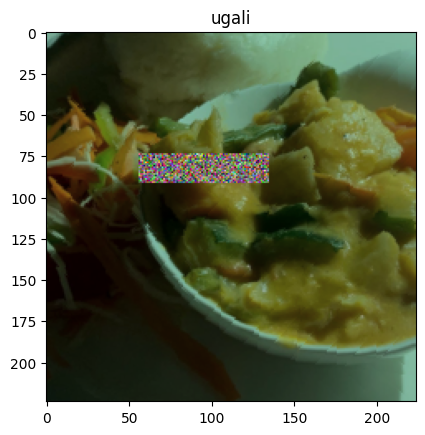

torch.Size([224, 224, 3])


In [21]:
for test_batch_0, labels in  train_loader[0]:
    rd_idx = np.random.randint(30)
    img = test_batch_0[rd_idx]
    img = denormalize(img)
    img = img.permute(1,2,0)
    plt.imshow(img)
    plt.title(all_labels[labels[rd_idx].item()])
    plt.show()
    print(img.shape)
    break

## <font style="color:green">2. Configuration [5 Points]</font>

**Define your configuration here.**

For example:


```python
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 10 
    epochs_count: int = 50  
    init_learning_rate: float = 0.1  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = "/kaggle/input/opencv-pytorch-project-2-classification-round-3" 
    num_workers: int = 2  
    device: str = 'cuda'  
    
```

In [22]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    image_size: int = (224, 224) 
    number_class: int = 13 
    batch_size: int = 32 
    epochs_count: int = 20
    init_learning_rate: float = 0.001  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = "/kaggle/input/opencv-pytorch-project-2-classification-round-3" 
    num_workers: int = 4  
    device: str = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## <font style="color:green">3. Evaluation Metric [10 Points]</font>

**Define methods or classes that will be used in model evaluation. For example, accuracy, f1-score etc.**

In [23]:
def accuracy_scores(y_pred, y_true):
    corect_prediction = torch.sum(y_pred == y_true)
    total_prediction =  len(y_true)

    return corect_prediction/total_prediction

In [24]:
def save_images_tensorboard(images, labels, number, text = "Training Images", step = 0):
    for i in range(number):
        img = (denormalize(images[i]) * 255).byte()
        
        img_with_label = draw_bounding_boxes(
            img,
            boxes=torch.zeros((0, 4), dtype=torch.float32),  # obligatoire si pas de boxes
            labels=[str(all_labels[labels[i].item()])],
        )
    
        #img_to_show = img_with_label.permute(1, 2, 0)
        #plt.imshow(img_to_show)
        #plt.title(f"Label: {all_labels[labels[i].item()]}")
        #plt.axis("off")
        #plt.show()
        
        writer.add_image(text , img_with_label, step)

## <font style="color:green">4. Train and Validation [5 Points]</font>


**Write the methods or classes to be used for training and validation.**

In [25]:
def train_one_epoch(model, optimizer, train_config, dataloader, class_weights, metrics, accuracy, device, num_batch=None, epoch=0):
    
    model.train()
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

    # reset metrics
    f1score, confmat = metrics
    f1score.reset()
    confmat.reset()

    # subset of batches
    if num_batch is not None:
        data = list(itertools.islice(dataloader, num_batch))
    else:
        data = dataloader

    pbar = tqdm(data, desc=f"Epoch {epoch+1}/{train_config.epochs_count} [Training")

    train_loss = 0.0
    train_acc  = 0.0

    for batch_idx, (imgs, labels) in enumerate(pbar):
        imgs, labels = imgs.to(device), labels.to(device)

        # forward
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        # backward
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        # metrics
        preds = outputs.argmax(dim=1)
        acc = accuracy(preds, labels)

        train_loss += loss.item()
        train_acc  += acc
        f1score.update(preds, labels)

        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc":  f"{train_acc/(batch_idx+1):.4f}",
            "f1":   f"{f1score.compute():.4f}",
        })

    # epoch metrics
    train_loss = train_loss / len(data)
    train_acc  = train_acc  / len(data)
    train_f1   = f1score.compute().item()

    return train_loss, train_acc, train_f1

In [26]:
def val_one_epoch(model, train_config, val_loader, device, accuracy, metrics):

    model.eval()

    criterion = nn.CrossEntropyLoss()
    f1score, confmat = metrics
    confmat.reset()
    f1score.reset()

    val_loss, val_acc = 0.0, 0.0

    epochs = train_config.epochs_count

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            # Forward
            outputs = model(imgs)       
            probs = torch.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)          # classes prédictes
            loss = criterion(outputs, labels)      # perte calculée sur logits

            # Update metrics
            val_loss += loss.item()
            acc  = accuracy(preds, labels)
            val_acc += acc
            f1score.update(preds, labels)
            confmat.update(preds, labels)

    # Summary Validation
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    val_f1 = f1score.compute().item()
    val_mat = confmat.compute()

    return val_loss, val_acc, val_f1, val_mat


## <font style="color:green">5. Model [5 Points]</font>

**Define your model in this section.**

**You are allowed to use any pre-trained model.**

In [27]:
#B0 → 224×224  B1 → 240×240 B2 → 260×260 B3 → 300×300
#B4 → 380×380  B5 → 456×456 B6 → 528×528 B7 → 600×600

# EfficientNetV2‑L;  EfficientNetV2‑S;  EfficientNet‑B7; EfficientNet‑B4; EfficientNet‑B0
# Xinception et Densnet
def efficient():
    #model = models.efficientnet_b0(pretrained=True)
    weights = models.EfficientNet_B4_Weights.DEFAULT
    model = models.efficientnet_b4(weights=weights)
    
    num_classes = 13  
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    model.classifier[0].p = 0.8
    
    # 3. Geler les features (optionnel)
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Débloquer le dernier bloc (par ex. le dernier élément de model.features)
    for param in model.features[-2:].parameters():
        param.requires_grad = True

In [28]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

# Charger ResNet50 pré-entraîné sur ImageNet
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

# Adapter la dernière couche pour ton dataset
num_classes = 13
model.fc = nn.Linear(model.fc.in_features, num_classes)

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:  # dernier bloc + fully connected
        param.requires_grad = True
    else:
        param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 229MB/s]


In [29]:
model.fc = nn.Sequential(
    nn.Dropout(p=0.8),  # Dropout avant la couche finale
    nn.Linear(model.fc.in_features, num_classes)
)

In [30]:
model.to("cuda" if torch.cuda.is_available() else "cpu")
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## <font style="color:green">6. Utils [5 Points]</font>

**Define those methods or classes, which have  not been covered in the above sections.**

In [31]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [32]:
def to_float(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().item()
    return float(x)

def plot_metrics(liveloss, log_loss, log_accuracy):
    metrics = {
        'log loss': to_float(log_loss[0]),
        'val_log loss': to_float(log_loss[1]),
        'accuracy': to_float(log_accuracy[0]),
        'val_accuracy': to_float(log_accuracy[1])
    }
    liveloss.update(metrics)
    liveloss.send()

In [33]:
date_time_str = datetime.now().strftime("%m-%d_%H-%M")
writer = SummaryWriter(f"runs/experiment_{date_time_str}")
model_save_path = f"model/version_{date_time_str}"
os.makedirs("val_log",  exist_ok=True)
filename = f"val_log/val_log_{date_time_str}.txt"

In [34]:
writer = SummaryWriter(f"runs/experiment_{date_time_str}")

def maim(model, optimizers, train_config):

    image_size = train_config.image_size
    num_class = train_config.number_class
    batch_size = train_config.batch_size
    num_workers = train_config.num_workers
    device = train_config.device
    epochs = train_config.epochs_count
    root_path = train_config.data_root
    test_path = os.path.join(root_path, 'test.csv')
    train_path = os.path.join(root_path, 'train.csv')
    image_path = os.path.join(root_path, 'images/images') 
    

    optimizer, scheduler1, scheduler2  = optimizers(model, train_config)
    early_stopping = EarlyStopping(patience=10, min_delta=1e-7)
    
    # Evaluation metric for the model
    ref_loss = float('inf')
    accuracy = accuracy_scores
    confmat = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=num_class).to(device)
    f1score = torchmetrics.F1Score(task="multiclass", num_classes=num_class).to(device)
    metrics = [f1score, confmat]
    
    # get data
    train_loaders, test_loader, weight, all_labels = get_data(train_path, 
                                         test_path, 
                                         image_size, 
                                         image_path, 
                                         data_aug = True, 
                                         batch_size = batch_size, 
                                         num_workers = num_workers)

    
    train_loader, valid_loader = train_loaders

    # save 5 image in tensorboard
    train_images, train_labels = next(iter(train_loader))
    val_images, val_labels = next(iter(valid_loader))
    save_images_tensorboard(train_images, train_labels, 10, text = "Training Images", step = 0)
    save_images_tensorboard(val_images, val_labels, 10, text = "Validation Images", step = 0)
    liveloss = PlotLosses(outputs=[MatplotlibPlot(cell_size=(7, 3)), ExtremaPrinter()])
    
    for epoch in range(epochs):
 
        start = time.time()
        train_loss, train_acc, train_f1 =train_one_epoch(model = model, 
                                                         optimizer = optimizer,
                                                        train_config = train_config, 
                                                        dataloader = train_loader, 
                                                        class_weights = weight,
                                                        metrics = metrics,
                                                        accuracy = accuracy,
                                                        device = device, 
                                                        num_batch=None, 
                                                        epoch = epoch)
        
        print(f"✅ Epoch {epoch+1}/{epochs} Training Summary: Loss={train_loss:.4f} | Acc={train_acc:.4f} | F1={train_f1:.4f} |LR={optimizer.param_groups[0]['lr']}|Time={(time.time() - start):.1f}s")
        
        start = time.time()
        val_loss, val_acc, val_f1, val_mat = val_one_epoch(model, 
                                                          train_config,
                                                          valid_loader, 
                                                          device, 
                                                          accuracy, 
                                                          metrics)
        #scheduler1.step()
        scheduler2.step(val_loss)
        log_val = f"📊 Epoch {epoch+1}/{epochs} Validation Summary: Loss={val_loss:.4f} | Acc={val_acc:.4f} | F1={val_f1:.4f} |LR={optimizer.param_groups[0]['lr']:.7f}'| Time={(time.time() - start):.1f}s"

        print(log_val)

        with open(filename, "a") as f:
            f.write(log_val + "\n")
    
        #plot metric and tensor-board
        if epoch % 1 == 0:
            plot_metrics(liveloss, [train_loss,val_loss], [train_acc,val_acc])

        # Tensorbord save scalare
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("Loss/val", val_loss, epoch)
        writer.add_scalar("Accuracy/train", train_acc, epoch)
        writer.add_scalar("Accuracy/val", val_acc, epoch)
        writer.add_scalar(f"LearningRate",optimizer.param_groups[0]['lr'], epoch)
        # Save weigth of model
        for name, param in model.named_parameters():
            writer.add_histogram(f"Weights/{name}", param, epoch)
            if param.grad is not None:
                writer.add_histogram(f"Gradients/{name}", param.grad, epoch)
                
        # Save the best models
        if ref_loss > val_loss:
            print(f"Model save augm {val_loss - (0 if ref_loss == 0 else ref_loss)} on epoch({epoch})")
            print(f"Model lr {optimizer.param_groups[0]['lr']})")

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': [train_loss, val_loss],
                'acc': [train_acc, val_acc]
            }, "checkpoint.pth")

        #Early stopping
        early_stopping(val_loss)

        if early_stopping.early_stop:
            print("⏹️ Early stopping déclenché")
            break

    return valid_loader, test_loader, all_labels

## <font style="color:green">7. Experiment [5 Points]</font>

**Choose your optimizer and LR-scheduler and use the above methods and classes to train your model.**

In [35]:
def get_optimizer(model, train_config):
    # Création de l’optimiseur
    #optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
     #                            lr=train_config.init_learning_rate,
      #                           weight_decay=5e-1)
    optimizer = torch.optim.SGD(model.parameters(), lr=train_config.init_learning_rate, momentum=0.9, weight_decay=1e-3)
    #AdamW
    #RMSprop
    #AdaGrad
    # Création du scheduler
    scheduler1 = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=40, 
        eta_min=1e-5)
    
    scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.6,
        patience=3,
    )

    return optimizer, scheduler1, scheduler2

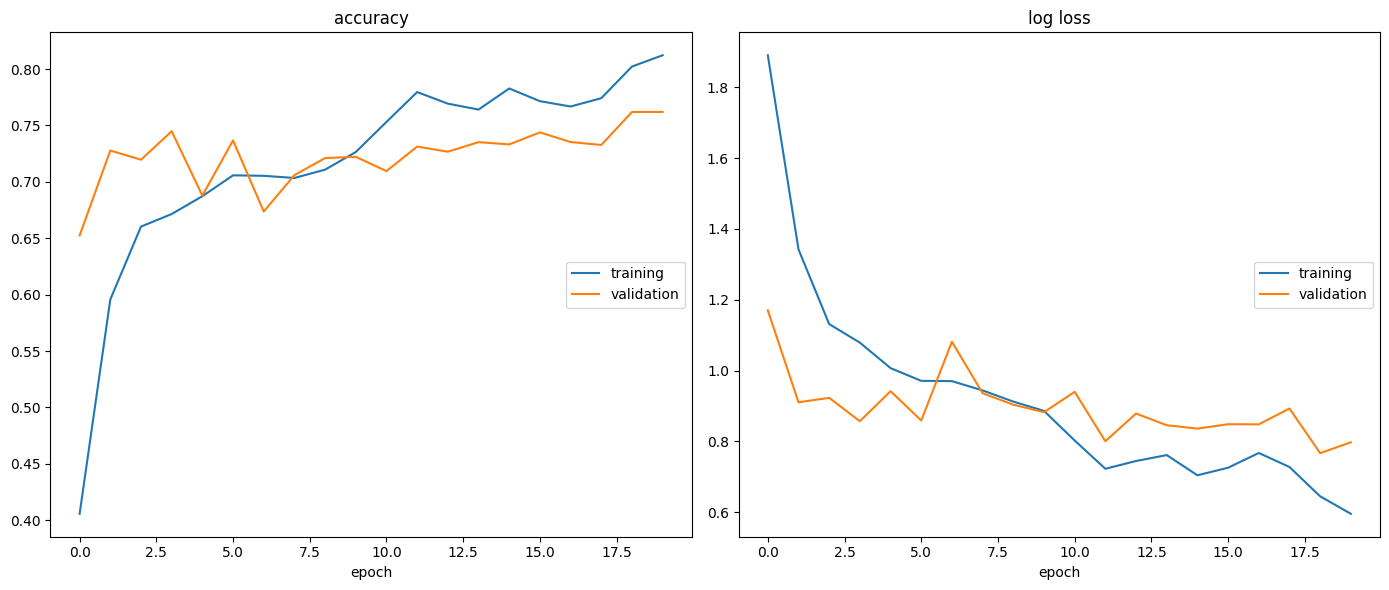

accuracy
	training         	 (min:    0.406, max:    0.812, cur:    0.812)
	validation       	 (min:    0.653, max:    0.762, cur:    0.762)
log loss
	training         	 (min:    0.596, max:    1.890, cur:    0.596)
	validation       	 (min:    0.767, max:    1.170, cur:    0.798)
Model save augm -inf on epoch(19)
Model lr 0.0036)


In [36]:
model = model.to("cuda" if torch.cuda.is_available() else "cpu")
valid_loader, test_loader, all_labels = maim(model = model, optimizers = get_optimizer, train_config = TrainingConfiguration)

## <font style="color:green">8. TensorBoard Log Link [5 Points]</font>

**Share your TensorBoard scalars logs link here You can also share (not mandatory) your GitHub link, if you have pushed this project in GitHub.**


Note: In light of the recent shutdown of tensorboard.dev, we have updated the submission requirements for your project. Instead of sharing a tensorboard.dev link, you are now required to upload your generated TensorBoard event files directly onto the lab. As an alternative, you may also include a screenshot of your TensorBoard output within your Jupyter notebook. This adjustment ensures that your data visualization and model training efforts are thoroughly documented and accessible for evaluation.

You are also welcome (and encouraged) to utilize alternative logging services like wandB or comet. In such instances, you can easily make your project logs publicly accessible and share the link with others.

In [37]:
# Load the model
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

num_classes = 13
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.fc = nn.Sequential(
    nn.Dropout(p=0.8),  
    nn.Linear(model.fc.in_features, num_classes)
)
checkpoint = torch.load("checkpoint.pth", weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [38]:
path = "runs"   # dossier parent
subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

# Trier alphabétiquement
subdirs.sort()

# Prendre le dernier
last_subdir = subdirs[-1]
last_subdir

'experiment_11-22_15-48'

In [39]:
%load_ext tensorboard
%tensorboard --logdir 'experiment_2025-11-18_22-15' --host 0.0.0.0 --port 6008

<IPython.core.display.Javascript object>

## <font style="color:green">9. Kaggle Profile Link [50 Points]</font>

**Share your Kaggle profile link  with us here to score , points in  the competition.**

**For full points, you need a minimum accuracy of `75%` on the test data. If accuracy is less than `70%`, you gain  no points for this section.**


**Submit `submission.csv` (prediction for images in `test.csv`), in the `Submit Predictions` tab in Kaggle, to get evaluated for  this section.**

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torchvision/utils.py:211: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


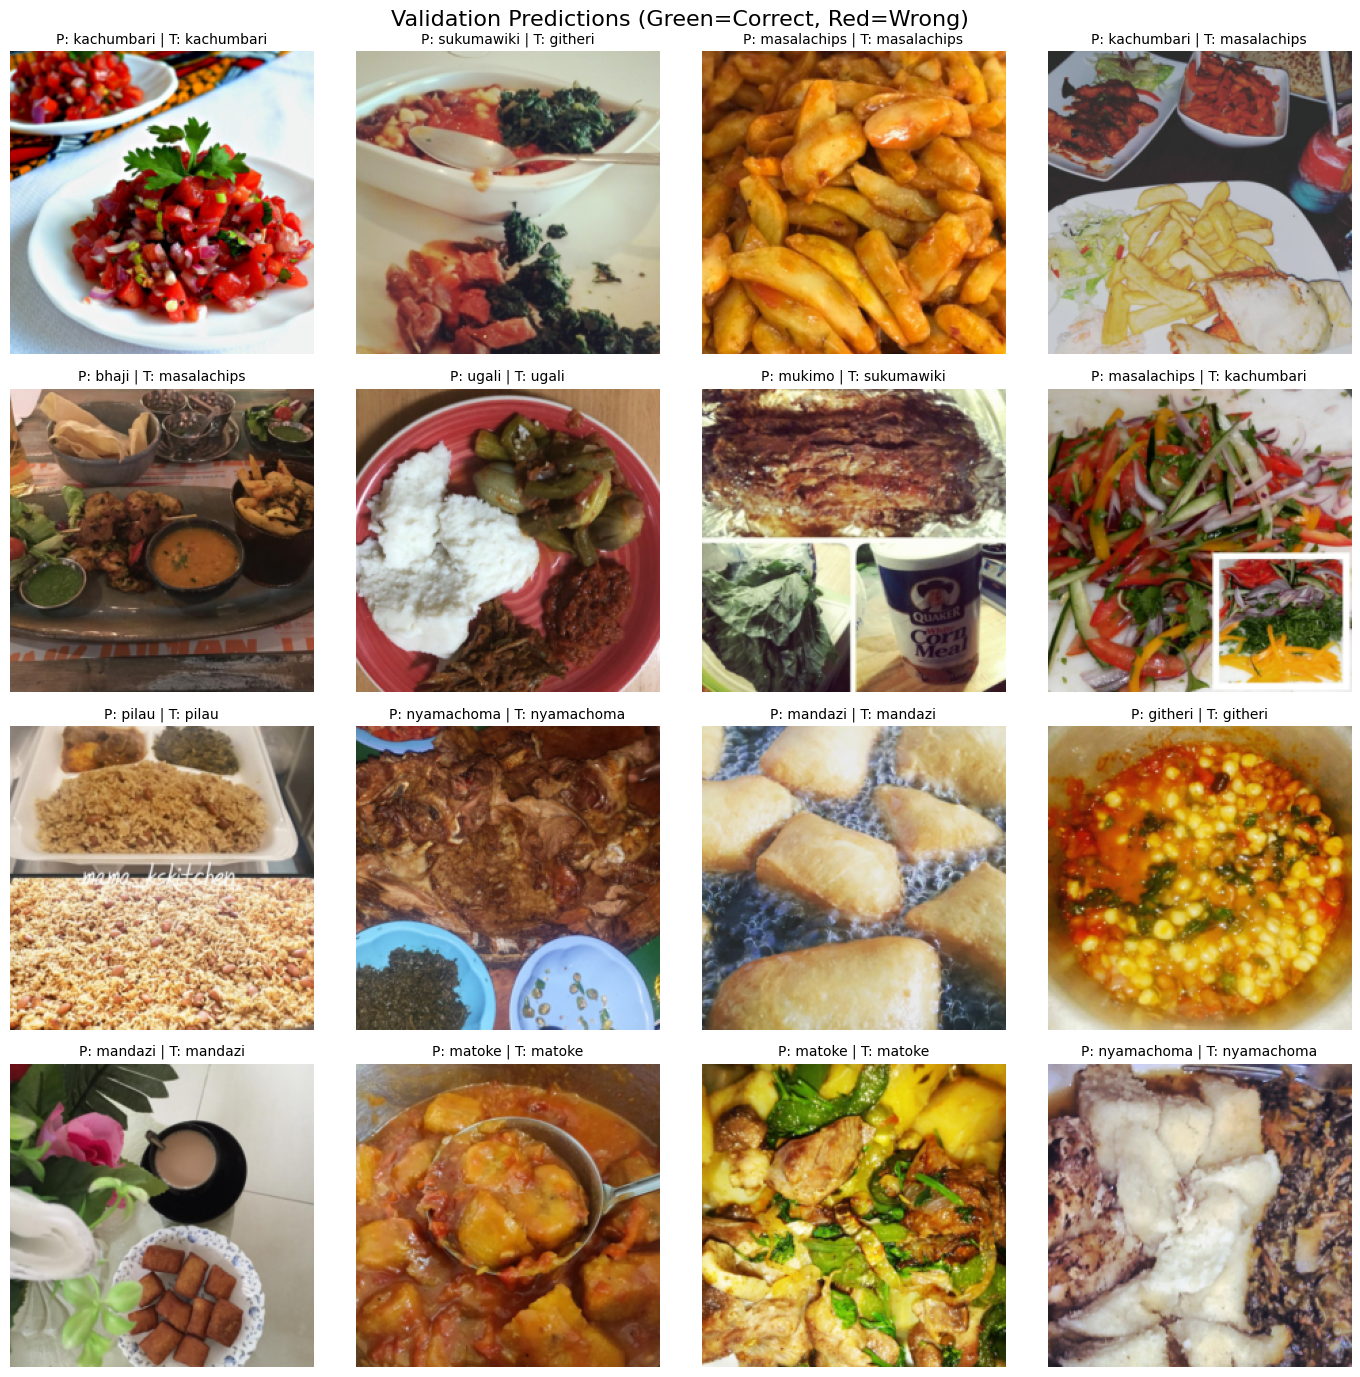

In [40]:
from torchvision.utils import draw_bounding_boxes, make_grid
import matplotlib.pyplot as plt

val_images, val_labels = next(iter(train_loader[1]))

model.eval()
with torch.no_grad():
    outputs = model(val_images)
    _, preds = outputs.max(1)

# ---- Save to TensorBoard ----
save_images_tensorboard(val_images, preds, number=10, text="Validation Predictions", step=0)

# Plot results
plt.figure(figsize=(14, 14))

for idx, (img_tensor, true_label, pred_label) in enumerate(zip(val_images, val_labels, preds)):

    # denormalize + uint8
    img = (denormalize(img_tensor) * 255).byte()

    # labels
    label_true = all_labels[true_label.item()]
    label_pred = all_labels[pred_label.item()]

    # color
    color = "red" if pred_label != true_label else "green"
    text = f"P: {label_pred} | T: {label_true}"

    img_annot = draw_bounding_boxes(
        img,
        boxes=torch.zeros((0, 4), dtype=torch.float32),
        labels=[text],
        colors=[color],
        font_size=30,      # ← très important
        width=3 
    )
    
    # convert CHW → HWC for matplotlib
    img_show = img_annot.permute(1, 2, 0)

    # ---- add to subplot ----
    plt.subplot(4, 4, idx + 1)
    plt.imshow(img_show)
    plt.axis("off")
    plt.title(text, fontsize=10)

    if idx == 15:       # 8 images max
        break

plt.suptitle("Validation Predictions (Green=Correct, Red=Wrong)", fontsize=16)
plt.tight_layout()
plt.show()

In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, input_tensor, batch_form=False):
        self.model = model
        self.input_tensor = input_tensor if batch_form else input_tensor.unsqueeze(0) # ajouter batch dim si nécessaire
        self.gradients = []
        self.activations = []
        self.cams = None

    # --- hooks
    def forward_hook(self, module, input, output):
        self.activations.append(output)

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients.append(grad_output[0])

    # --- opérateur Grad-CAM
    def operate_grad_cam(self):
        # cible la dernière feature map
        target_layer = self.model.layer4[-1].conv3
        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

        # forward pass
        self.model.eval()
        output = self.model(self.input_tensor)
        pred_class = output.argmax(1).item()

        # backward pass sur la classe prédite
        self.model.zero_grad()
        output[0, pred_class].backward()

        # calcul du Grad-CAM
        activation = self.activations[0]    # [1, C, H, W]
        gradient = self.gradients[0]        # [1, C, H, W]

        # pondération moyenne des gradients par carte de feature map
        weights = gradient.mean(dim=(2,3), keepdim=True)  # [1, C, 1, 1]

        # somme pondérée des activations
        cam = (activation * weights).sum(dim=1, keepdim=True)  # [1, 1, H, W]
        cam = torch.relu(cam)
        cam = cam.squeeze().detach().cpu().numpy()
        cam = cam / cam.max()  # normalisation
        self.cams = cam

        return pred_class

    # --- affichage
    def plot_grad_cam(self):
        import cv2

        img = self.input_tensor.squeeze().permute(1,2,0).cpu().numpy()  # HWC
        img = (img - img.min()) / (img.max() - img.min())  # normalize to [0,1]

        heatmap = cv2.resize(self.cams, (img.shape[1], img.shape[0]))
        plt.imshow(img)
        plt.imshow(heatmap, cmap='jet', alpha=0.5)
        plt.axis('off')
        plt.show()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


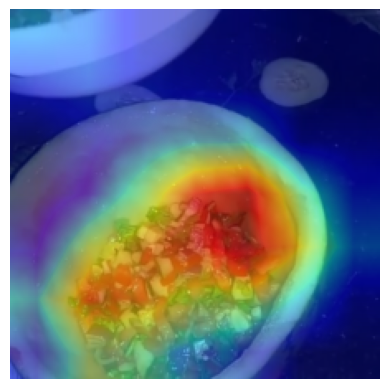

Predicted class: ('kachumbari', 'kachumbari')


In [42]:
img_tensor = val_images[20]
true_class = val_labels[20]
grad_cam = GradCAM(model, img_tensor)
pred_class = grad_cam.operate_grad_cam()
grad_cam.plot_grad_cam()
print("Predicted class:", (all_labels[pred_class], all_labels[true_class]))

In [43]:
import pandas as pd
import torch

df_text = pd.read_csv(test_path)
model.eval()

all_preds = []

with torch.no_grad():
    for test_images in test_loader:
        outputs = model(test_images)
        _, preds = outputs.max(1)
        # Convertir indices → labels
        all_preds.extend([all_labels[idx] for idx in preds.cpu().numpy()])

# Créer le DataFrame en une seule fois
df_submission = pd.DataFrame({
    "id": df_text["id"].values,
    "class": all_preds
})

df_submission.to_csv("submission1.csv", index=False)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
